In [1]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List
from astropy.table import Table
from astropy.io import ascii

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

from gaia_download import gaia_get_dr2_in_dr3, get_photogeometric_distances

from extinction import add_colors_and_abs_mag

Configuration file not found:

    /home/maya/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [10]:
GAIA_EDR3_BIBCODE: str = '2020yCat.1350....0G'
WYIN_BIBCODE: str = '2008AJ....135.2264G'

In [11]:
GAIA_COLUMNS: List[str] = ['ra', 'dec', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
                           'parallax', 'parallax_error', 'parallax_over_error',
                           'ruwe', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
                           'distance', 'distance_minus_error', 'distance_plus_error',
                           'phot_g_mean_flux_over_error', 'phot_rp_mean_flux_over_error', 'phot_bp_mean_flux_over_error',
                           'bp_rp', 'phot_bp_rp_excess_factor', 'radial_velocity', 'radial_velocity_error']

In [12]:
RA: float = 11.7980
DEC: float = 85.2440
    
COLUMNS: List[str] = ['ra', 'dec', 'distance', 'pmra', 'pmdec']
    
CLUSTER_NAME: str = 'NGC 188'
DEGREES: int = 1

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [13]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/2_deg_w_photogeo.csv', index_col=None).rename(
    columns={'r_med_photogeo': 'distance',
             'photogeo_minus_error': 'distance_minus_error',
             'photogeo_plus_error': 'distance_plus_error'}
)

In [14]:
sources.head()

,Unnamed: 0,source_id,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,distance,distance_minus_error,distance_plus_error
0,0,574509467058245248,1636148068921376768,Gaia DR3 574509467058245248,1493410390,2016.0,35.762865,0.029851,85.164665,0.029967,...,0.1852,0.1610,0.2085,0.0981,0.0852,0.1104,MARCS,1746.8107,119.5533,92.7570
1,2,574509497122165760,1636148068921376768,Gaia DR3 574509497122165760,998946401,2016.0,35.790532,0.125888,85.170221,0.133328,...,0.0132,0.0035,0.0310,0.0071,0.0019,0.0167,PHOENIX,1544.8680,190.4556,200.4380
2,3,574509634560358272,1636148068921376768,Gaia DR3 574509634560358272,1157546964,2016.0,35.942416,0.145537,85.191924,0.142934,...,0.0024,0.0006,0.0068,0.0013,0.0003,0.0037,PHOENIX,1887.1810,239.1794,185.7640
3,4,574512555138118272,1636148068921376768,Gaia DR3 574512555138118272,1114709481,2016.0,35.841332,0.352966,85.192230,0.388702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3043.5544,420.0976,422.9649
4,5,574512589497861248,1636148068921376768,Gaia DR3 574512589497861248,904768323,2016.0,35.884952,0.044741,85.209943,0.046085,...,0.1804,0.1564,0.2034,0.0955,0.0828,0.1077,PHOENIX,1359.8809,49.2227,176.3681


In [15]:
sources['distance_error'] = np.mean(sources[['distance_minus_error', 'distance_plus_error']].values, axis=1)

# Preprocessing

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [16]:
def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def normalize(sources: pd.DataFrame,
              columns: List[str],
              with_errors: bool = False) -> pd.DataFrame:
    scaler = StandardScaler()
    
    s = scaler.fit_transform(sources[columns])
    
    if with_errors:
        err_columns = [f'{c}_error' for c in columns]
        rescaled_errors = sources[err_columns].values*scaler.scale_
        s = np.concatenate([s, rescaled_errors], axis=1)
    return s

def prepare_data_for_clustering(sources: pd.DataFrame,
                                columns: List[str]) -> pd.DataFrame:
    return wrap_coordinates(
        clean_nans(
            sources,
            columns
        )
    )

In [17]:
sources_to_cluster = prepare_data_for_clustering(sources, COLUMNS)
sources_normalized = normalize(sources_to_cluster, COLUMNS)

After dropping NaNs from ['ra', 'dec', 'distance', 'pmra', 'pmdec']: 48270


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Normalization scales the features to an unit variance.

In [18]:
def plot_on_aitoff(sources: pd.DataFrame, cluster_name: str, degrees: float):
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources.ra,
                                          dec=sources.dec,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    plt.figure(figsize=(10, 7));
    plt.subplot(111, projection="aitoff");
    plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon',
                label=f'{cluster_name} center$\pm {degrees}^\circ$');
    plt.grid();
    plt.legend(loc='lower right', fontsize=14);

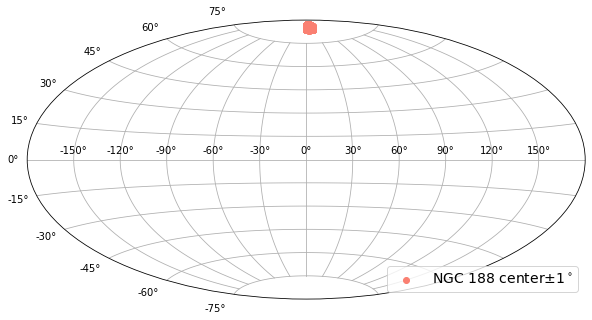

In [19]:
plot_on_aitoff(sources_to_cluster, CLUSTER_NAME, DEGREES)

# Comparision: NGC 188 cluster members from literature

In [20]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


# DBSCAN

In [21]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5, min_samples=20) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_fit = dbscan_clust.fit(sources)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels: {unique_labels}')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array,
                            label = None) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    if not label:
        largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    else:
        largest_non_noise = label
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

In [22]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

def contaminants(clustered: pd.DataFrame) -> int:
    return len(clustered[(clustered.ra > 25) | (clustered.ra < 0) | (clustered.dec > 86.5) | (clustered.dec < 84)])

In [23]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

def check_for_undiscovered_sources(from_lit: pd.DataFrame,
                                   cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(from_lit, 'EDR3 id')
    in_cluster = np.vectorize(is_in_cluster)(cluster_sources['source_id'].values)
    falses = in_cluster[~in_cluster]
    print(f'{len(falses)}/{len(in_cluster)} objects were previously unreported.')
    return len(falses)/len(in_cluster)

In [24]:
is_in_edr3 = is_in_cluster_function(sources_to_cluster)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [25]:
labels = dbscan(sources_normalized, eps=.5, min_samples=200)
labelled_sources = label_sources(sources_to_cluster, labels)
labelled_sources.label.value_counts()

Classified into 3 labels: {0, 1, -1}


-1    41740
 0     4100
 1     2430
Name: label, dtype: int64

# Execute a grid search for eps and min_samples

In [26]:
eps_values = np.linspace(0.25, 1.0, 5)
min_samples_values = [int(m) for m in np.linspace(10, 500, 10)]

In [27]:
contaminant_values = []
completness_values = []
best_labels = []

hyperparam_values = []

In [124]:
for eps_value in eps_values:
    for min_samples_value in min_samples_values:
        print(f'eps={eps_value}, min_samples={min_samples_value}:')
        
        labels = dbscan(sources_normalized, eps=eps_value, min_samples=min_samples_value)
        labelled_sources = label_sources(sources_to_cluster, labels)
        labelled_sources.label.value_counts()
        
        label_unique_values = np.unique(labels[labels!=-1])
        
        if len(label_unique_values) == 0:
            continue
        
        if len(label_unique_values) == 1:
            best_labels.append(0)
            clustered, _ = get_clustered_and_noise(labelled_sources, labels, 0)
            completness_values.append(len(from_lit_edr3[check_for_cluster_children(from_lit_edr3, clustered)]))
            hyperparam_values.append([eps_value, min_samples_value])
            contaminant_values.append(contaminants(clustered))
            continue
            
        completness_per_label = []
        contaminants_per_label = []
        for label in label_unique_values:
                clustered, _ = get_clustered_and_noise(labelled_sources, labels, label)
                completness_per_label.append(len(from_lit_edr3[check_for_cluster_children(from_lit_edr3, clustered)]))
                contaminants_per_label.append(contaminants(clustered))
        
        hyperparam_values.append([eps_value, min_samples_value])
        completness_values.append(np.max(completness_per_label))
        contaminant_values.append(contaminants_per_label[np.argmax(completness_per_label)])
        best_labels.append(label_unique_values[np.argmax(completness_per_label)])
    

eps=0.25, min_samples=10:
Classified into 119 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, -1}
Clustered: 1408/48270
1189/1309 objects found in the cluster.
Clustered: 10/48270
0/1309 objects found in the cluster.
Clustered: 31/48270
0/1309 objects found in the cluster.
Clustered: 12/48270
0/1309 objects found in the cluster.
Clustered: 45/48270
0/1309 objects found in the cluster.
Clustered: 10/48270
0/1309 objects found in the cluster.
Clustered: 12/48270
0/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 objects found in the cluster.


1132/1309 objects found in the cluster.
eps=0.25, min_samples=500:
Classified into 2 labels: {0, -1}
Clustered: 1212/48270
1121/1309 objects found in the cluster.
eps=0.4375, min_samples=10:
Classified into 18 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
Clustered: 37473/48270
1293/1309 objects found in the cluster.
Clustered: 11/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 14/48270
0/1309 objects found in the cluster.
Clustered: 16/48270
0/1309 objects found in the cluster.
Clustered: 12/48270
0/1309 objects found in the cluster.
Clustered: 7/48270
0/1309 objects found in the cluster.
Clustered: 11/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 objects found in the cluster.
Clustered: 16/48270
1/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 object

In [125]:
hyperparam_array = np.array(hyperparam_values)

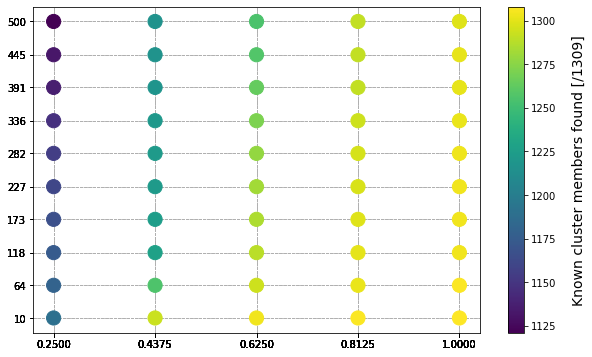

In [129]:
plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1], c=completness_values, zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label(f'Known cluster members found [/{len(from_lit_edr3)}]', fontsize=14, labelpad=15);

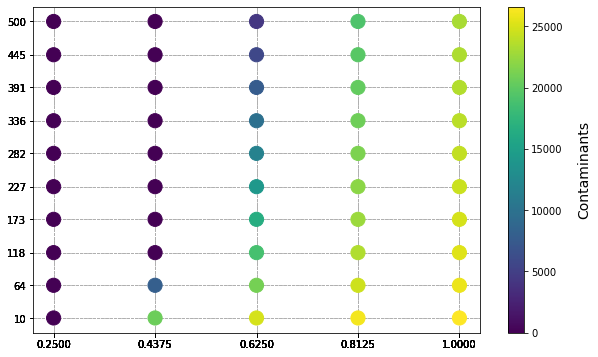

In [132]:
plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1], c=contaminant_values, zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label('Contaminants', fontsize=14, labelpad=15)

In [28]:
def efficiency(completness, contaminants) -> float:
    return completness if contaminants == 0 else completness/contaminants

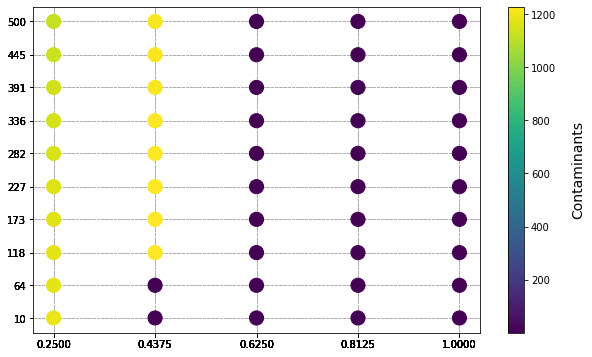

In [135]:
plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1],
            c=[efficiency(cm, cv) for cm, cv in zip(completness_values, contaminant_values)], zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label('Contaminants', fontsize=14, labelpad=15)

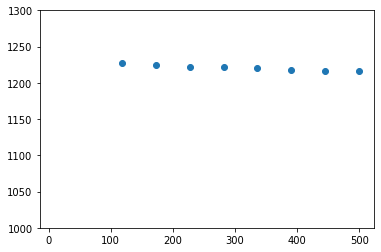

In [153]:
plt.scatter(hyperparam_array[10:21, 1],
            [efficiency(cm, cv) for cm, cv in zip(completness_values[10:21], contaminant_values[10:21])])
plt.gca().set_ylim(1000, 1300);

In [159]:
contaminant_values = []
completness_values = []
best_labels = []

hyperparam_values = []

eps_values = np.linspace(0.4, 0.5, 10)

for eps_value in eps_values:
    for min_samples_value in min_samples_values:
        print(f'eps={eps_value}, min_samples={min_samples_value}:')
        
        labels = dbscan(sources_normalized, eps=eps_value, min_samples=min_samples_value)
        labelled_sources = label_sources(sources_to_cluster, labels)
        labelled_sources.label.value_counts()
        
        label_unique_values = np.unique(labels[labels!=-1])
        
        if len(label_unique_values) == 0:
            continue
        
        if len(label_unique_values) == 1:
            best_labels.append(0)
            clustered, _ = get_clustered_and_noise(labelled_sources, labels, 0)
            completness_values.append(len(from_lit_edr3[check_for_cluster_children(from_lit_edr3, clustered)]))
            hyperparam_values.append([eps_value, min_samples_value])
            contaminant_values.append(contaminants(clustered))
            continue
            
        completness_per_label = []
        contaminants_per_label = []
        for label in label_unique_values:
                clustered, _ = get_clustered_and_noise(labelled_sources, labels, label)
                completness_per_label.append(len(from_lit_edr3[check_for_cluster_children(from_lit_edr3, clustered)]))
                contaminants_per_label.append(contaminants(clustered))
        
        hyperparam_values.append([eps_value, min_samples_value])
        completness_values.append(np.max(completness_per_label))
        contaminant_values.append(contaminants_per_label[np.argmax(completness_per_label)])
        best_labels.append(label_unique_values[np.argmax(completness_per_label)])

eps=0.4, min_samples=10:
Classified into 25 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, -1}
Clustered: 34097/48270
1286/1309 objects found in the cluster.
Clustered: 9/48270
0/1309 objects found in the cluster.
Clustered: 19/48270
0/1309 objects found in the cluster.
Clustered: 10/48270
0/1309 objects found in the cluster.
Clustered: 14/48270
0/1309 objects found in the cluster.
Clustered: 12/48270
0/1309 objects found in the cluster.
Clustered: 24/48270
0/1309 objects found in the cluster.
Clustered: 32/48270
0/1309 objects found in the cluster.
Clustered: 20/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 objects found in the cluster.
Clustered: 30/48270
0/1309 objects found in the cluster.
Clustered: 12/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 objects found in the cluster.

Classified into 2 labels: {0, -1}
Clustered: 1644/48270
1214/1309 objects found in the cluster.
eps=0.4222222222222222, min_samples=500:
Classified into 2 labels: {0, -1}
Clustered: 1620/48270
1212/1309 objects found in the cluster.
eps=0.43333333333333335, min_samples=10:
Classified into 18 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
Clustered: 37159/48270
1292/1309 objects found in the cluster.
Clustered: 11/48270
0/1309 objects found in the cluster.
Clustered: 9/48270
0/1309 objects found in the cluster.
Clustered: 5/48270
0/1309 objects found in the cluster.
Clustered: 14/48270
0/1309 objects found in the cluster.
Clustered: 16/48270
0/1309 objects found in the cluster.
Clustered: 9/48270
0/1309 objects found in the cluster.
Clustered: 25/48270
0/1309 objects found in the cluster.
Clustered: 6/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 15/48270
0/1309 objects found in the cluster.
Clustere

0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
Clustered: 6/48270
0/1309 objects found in the cluster.
Clustered: 9/48270
0/1309 objects found in the cluster.
Clustered: 8/48270
0/1309 objects found in the cluster.
eps=0.4666666666666667, min_samples=64:
Classified into 2 labels: {0, -1}
Clustered: 22624/48270
1266/1309 objects found in the cluster.
eps=0.4666666666666667, min_samples=118:
Classified into 3 labels: {0, 1, -1}
Clustered: 10396/48270
1239/1309 objects found in the cluster.
Clustered: 111/48270
0/1309 objects found in the cluster.
eps=0.4666666666666667, min_samples=173:
Classified into 3 labels: {0, 1, -1}
Clustered: 2184/48270
1231/1309 objects found in the cluster.
Clustered: 2184/48270
1231/1309 objects found in the cluster.
eps=0.4666666666666667, min_samples=227:
Classified into 2 labels: {0, -1}
Clustered: 2115/48270
1231/1309 objects found in the cluster.
eps=0.4666666666666667, min_samples=282:
Classified into 2 label

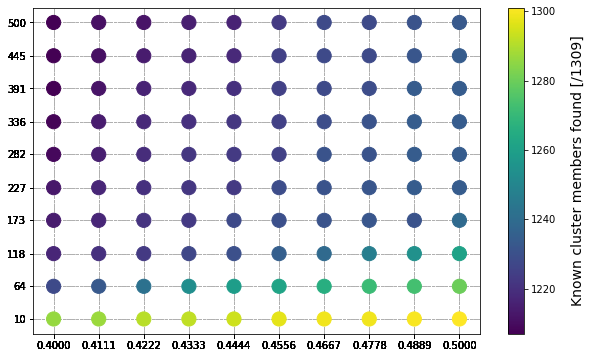

In [161]:
hyperparam_array = np.array(hyperparam_values)

plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1], c=completness_values, zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label(f'Known cluster members found [/{len(from_lit_edr3)}]', fontsize=14, labelpad=15);

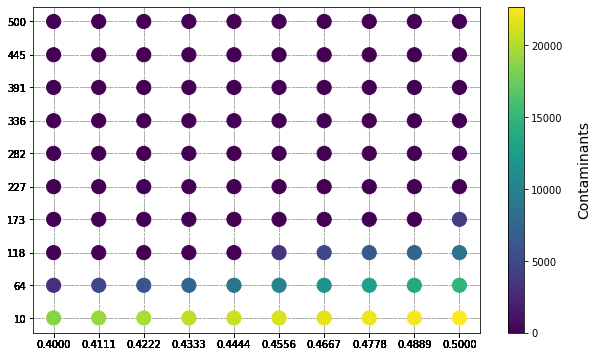

In [162]:
plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1], c=contaminant_values, zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label('Contaminants', fontsize=14, labelpad=15)

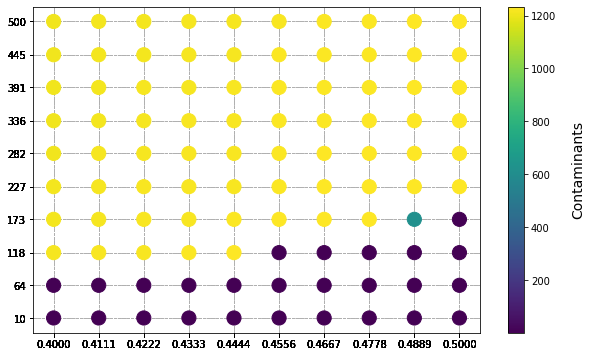

In [163]:
plt.figure(figsize=(10, 6));
plt.xticks(hyperparam_array[:, 0]);
plt.yticks(hyperparam_array[:, 1]);
plt.grid(linestyle='--', zorder=1);
plt.scatter(hyperparam_array[:, 0], hyperparam_array[:, 1],
            c=[efficiency(cm, cv) for cm, cv in zip(completness_values, contaminant_values)], zorder=2, s=200);
cbar=plt.colorbar();
cbar.set_label('Contaminants', fontsize=14, labelpad=15)

In [165]:
max([efficiency(cm, cv) for cm, cv in zip(completness_values, contaminant_values)])

1234.0

In [30]:
# hyperparam_array[np.argmax([efficiency(cm, cv) for cm, cv in zip(completness_values, contaminant_values)])]

In [31]:
labels = dbscan(sources_normalized, eps=.48, min_samples=227)
labelled_sources = label_sources(sources_to_cluster, labels)
labelled_sources.label.value_counts()

Classified into 2 labels: {0, -1}


-1    46037
 0     2233
Name: label, dtype: int64

In [32]:
clustered, noise = get_clustered_and_noise(labelled_sources, labels, 0)

Clustered: 2233/48270


In [33]:
def cluster_plot(clustered_sources: pd.DataFrame,
                 noise_sources: pd.DataFrame,
                 paper_sources: pd.DataFrame):
    plt.figure(figsize=(20, 10))
    plt.scatter(clustered_sources.ra, clustered_sources.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
    plt.scatter(noise_sources.ra, noise_sources.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
    plt.scatter(paper_sources.ra, paper_sources.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
    lgnd = plt.legend(fontsize=14);
    plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
    plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

    for handle in lgnd.legendHandles:
        handle._sizes = [30];

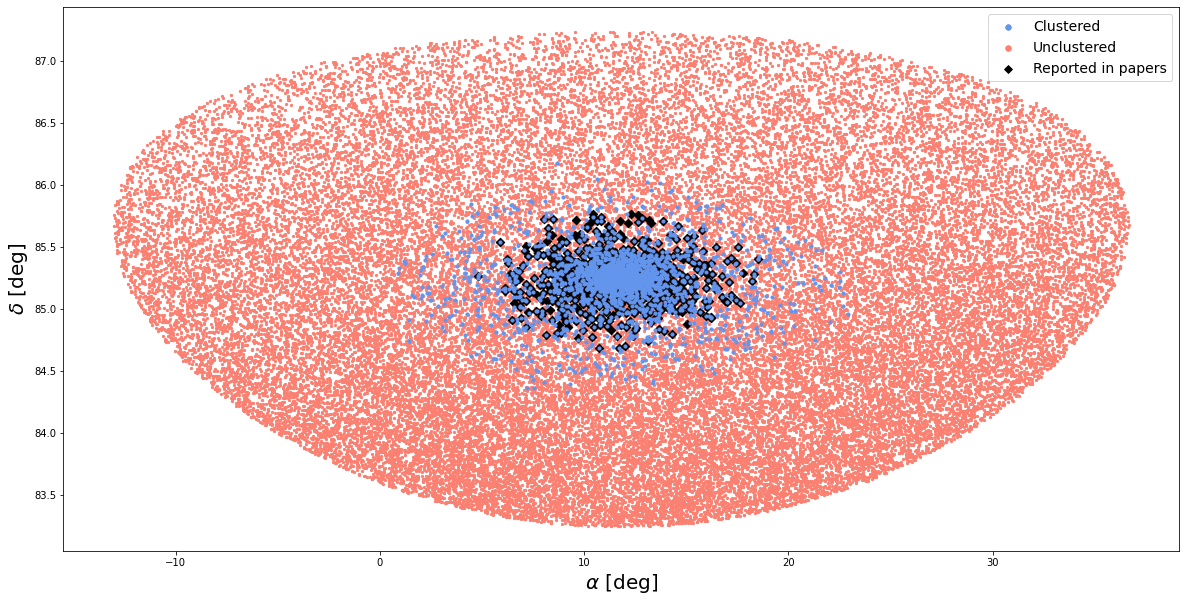

In [34]:
cluster_plot(clustered, noise, from_lit_edr3)

In [35]:
found_indices = check_for_cluster_children(from_lit_edr3, clustered)

1232/1309 objects found in the cluster.


In [36]:
missing = from_lit_edr3[~found_indices]

In [37]:
len(missing)

77

In [38]:
missing = missing[['EDR3 id', 'DR2 id', 'TIC']].set_index('EDR3 id').join(sources.set_index('source_id')[GAIA_COLUMNS])
missing.head()

,DR2 id,TIC,ra,dec,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,...,distance,distance_minus_error,distance_plus_error,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,bp_rp,phot_bp_rp_excess_factor,radial_velocity,radial_velocity_error
EDR3 id,,,,,,,,,,,,,,,,,,,,,
573990531930163200,5.739905e+17,461597662.0,9.621051,85.718865,2.556838,0.014558,-1.381951,0.014366,0.399452,0.012899,...,2352.4465,85.0664,82.1377,7196.8940,1688.4827,1396.32650,1.221737,1.234449,9.586292,3.707891
573982423031937536,5.739824e+17,461597611.0,9.531449,85.599899,-0.027991,0.017972,4.263475,0.018815,0.578460,0.015675,...,1642.4326,40.9441,46.6942,4973.0464,1039.2594,825.52734,0.853415,1.203021,10.268670,7.309325
573990222692531328,5.739902e+17,461599525.0,10.200667,85.677991,-2.638772,0.025555,7.123371,0.027732,0.585552,0.023847,...,1637.4222,61.7039,74.2950,2043.3815,564.4428,334.04560,0.977316,1.213376,NaN,NaN
573977062912759552,5.739771e+17,461601603.0,11.764065,85.605573,-1.418332,0.019181,3.335001,0.019611,0.607292,0.017275,...,1577.4236,31.8812,38.3219,4850.3633,1296.4186,646.04070,1.044548,1.216878,NaN,NaN
573935487629501056,5.739355e+17,461599168.0,10.477166,85.155422,2.837931,0.019382,0.035124,0.018560,0.497509,0.016096,...,1901.6815,52.2054,79.8388,5182.0767,1155.9647,836.64140,0.823558,1.199177,-16.822940,8.809947


In [39]:
def correct_flux_excess_factor(bp_rp, phot_bp_rp_excess_factor):
    """
    Calculate the corrected flux excess factor for the input Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    phot_bp_rp_excess_factor: float, numpy.ndarray
        The flux excess factor listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected value for the flux excess factor, which is zero for "normal" stars.
    
    Example
    -------
    
    phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(bp_rp, phot_bp_rp_flux_excess_factor)
    """
    
    if np.isscalar(bp_rp) or np.isscalar(phot_bp_rp_excess_factor):
        bp_rp = np.float64(bp_rp)
        phot_bp_rp_excess_factor = np.float64(phot_bp_rp_excess_factor)
    
    if bp_rp.shape != phot_bp_rp_excess_factor.shape:
        raise ValueError('Function parameters must be of the same shape!')
        
    do_not_correct = np.isnan(bp_rp)
    bluerange = np.logical_not(do_not_correct) & (bp_rp < 0.5)
    greenrange = np.logical_not(do_not_correct) & (bp_rp >= 0.5) & (bp_rp < 4.0)
    redrange = np.logical_not(do_not_correct) & (bp_rp > 4.0)
    
    correction = np.zeros_like(bp_rp)
    correction[bluerange] = 1.154360 + 0.033772*bp_rp[bluerange] + 0.032277*np.power(bp_rp[bluerange], 2)
    correction[greenrange] = 1.162004 + 0.011464*bp_rp[greenrange] + 0.049255*np.power(bp_rp[greenrange], 2) \
        - 0.005879*np.power(bp_rp[greenrange], 3)
    correction[redrange] = 1.057572 + 0.140537*bp_rp[redrange]
    
    return phot_bp_rp_excess_factor - correction

In [40]:
missing['excess'] = correct_flux_excess_factor(missing.bp_rp, missing.phot_bp_rp_excess_factor)

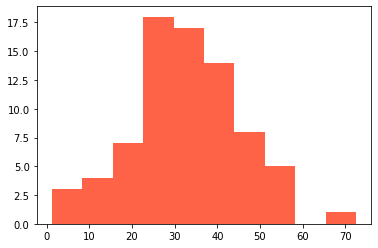

In [41]:
plt.hist(missing.parallax_over_error, color='tomato', bins=10);

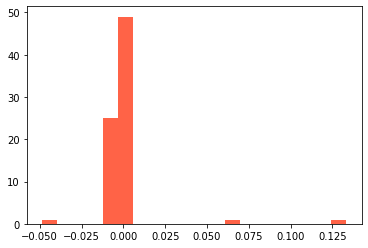

In [42]:
plt.hist(missing.excess, color='tomato', bins=20);

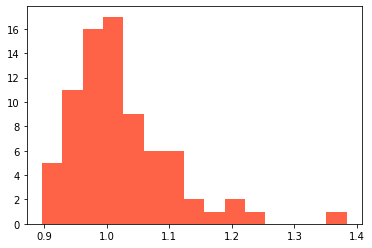

In [43]:
plt.hist(missing.ruwe, color='tomato', bins=15);

In [44]:
missing = add_colors_and_abs_mag(missing)
clustered = add_colors_and_abs_mag(clustered)

/home/maya/Workspace/gaia_blue/extinction.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources['BP_err'] = 2.5/(np.log(10)*sources['phot_bp_mean_flux_over_error'])
/home/maya/Workspace/gaia_blue/extinction.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources['RP_err'] = 2.5/(np.log(10)*sources['phot_rp_mean_flux_over_error'])
/home/maya/Workspace/gaia_blue/extinction.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

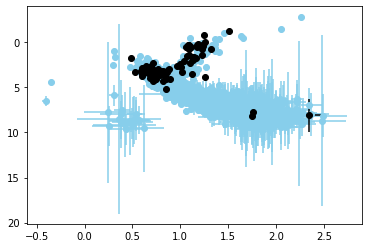

In [45]:
plt.errorbar(clustered.color, clustered.mag_abs, xerr=clustered.color_err, yerr=clustered.mag_abs_err,
             fmt='o', color='skyblue');
plt.errorbar(missing.color, missing.mag_abs, xerr=missing.color_err, yerr=missing.mag_abs_err,
             fmt='o', color='black');
plt.gca().invert_yaxis();

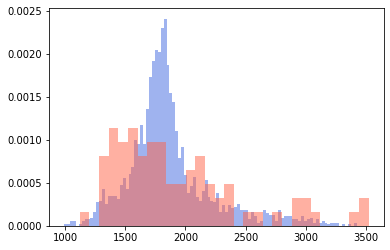

In [46]:
plt.hist(clustered.distance, bins=100, density=True, color='royalblue', alpha=.5);
plt.hist(missing.distance, bins=30, density=True, color='tomato', alpha=.5);

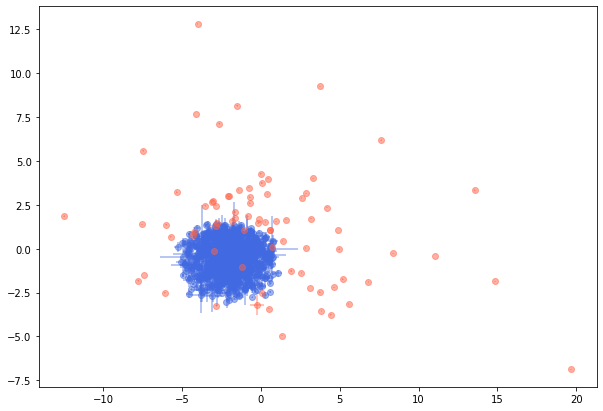

In [47]:
plt.figure(figsize=(10, 7))
plt.errorbar(clustered.pmra, clustered.pmdec,
             xerr=clustered.pmra_error, yerr=clustered.pmdec_error,
             color='royalblue', alpha=.5, fmt='o');
plt.errorbar(missing.pmra, missing.pmdec,
             xerr=missing.pmra_error, yerr=missing.pmdec_error,
             color='tomato', alpha=.5, fmt='o');

In [48]:
PMRA_MEAN = np.mean(clustered.pmra)
PMDEC_MEAN = np.mean(clustered.pmdec)
PMRA_STD = np.std(clustered.pmra)
PMDEC_STD = np.std(clustered.pmdec)

In [49]:
missing_pm = (np.abs(missing.pmra-PMRA_MEAN)<3*PMRA_STD) & (np.abs(missing.pmdec-PMDEC_MEAN)<3*PMDEC_STD)

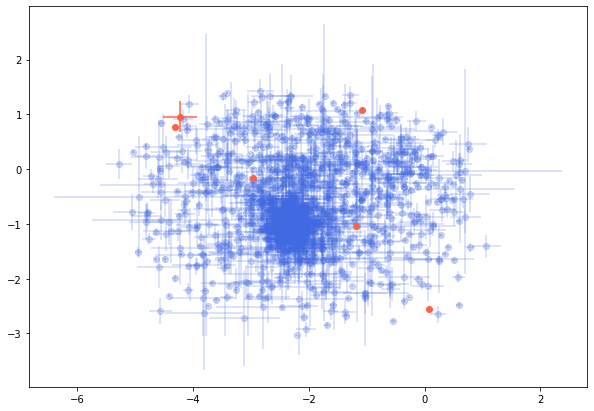

In [50]:
plt.figure(figsize=(10, 7))
plt.errorbar(clustered.pmra, clustered.pmdec,
             xerr=clustered.pmra_error, yerr=clustered.pmdec_error,
             color='royalblue', alpha=.25, fmt='o');
plt.errorbar(missing[missing_pm].pmra, missing[missing_pm].pmdec,
             xerr=missing[missing_pm].pmra_error, yerr=missing[missing_pm].pmdec_error,
             color='tomato', fmt='o');

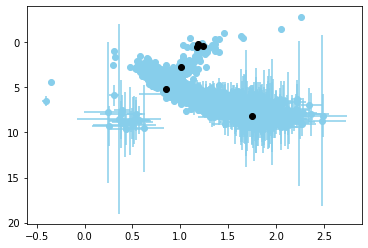

In [51]:
plt.errorbar(clustered.color, clustered.mag_abs, xerr=clustered.color_err, yerr=clustered.mag_abs_err,
             fmt='o', color='skyblue');
plt.errorbar(missing[missing_pm].color, missing[missing_pm].mag_abs,
             xerr=missing[missing_pm].color_err, yerr=missing[missing_pm].mag_abs_err,
             fmt='o', color='black');
plt.gca().invert_yaxis();

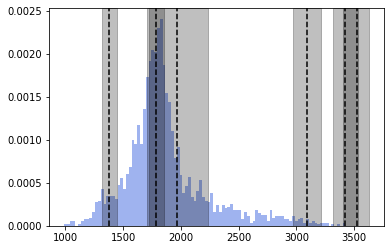

In [52]:
plt.hist(clustered.distance, bins=100, density=True, color='royalblue', alpha=.5);

for _, m in missing[missing_pm].iterrows():
    plt.axvline(m.distance, ymin=0., ymax=1., linestyle='--', color='black');
    plt.axvspan(m.distance-m.distance_minus_error, m.distance+m.distance_plus_error, color='black', alpha=.25)

In [53]:
missing_dist = missing[missing_pm][missing.distance<3000]

<ipython-input-53-97a91f7099f1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_dist = missing[missing_pm][missing.distance<3000]


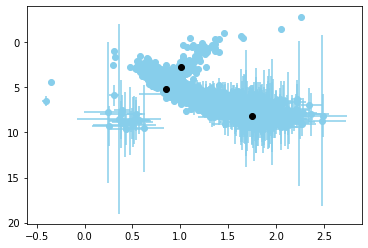

In [54]:
plt.errorbar(clustered.color, clustered.mag_abs, xerr=clustered.color_err, yerr=clustered.mag_abs_err,
             fmt='o', color='skyblue');
plt.errorbar(missing_dist.color, missing_dist.mag_abs,
             xerr=missing_dist.color_err, yerr=missing_dist.mag_abs_err,
             fmt='o', color='black');
plt.gca().invert_yaxis();

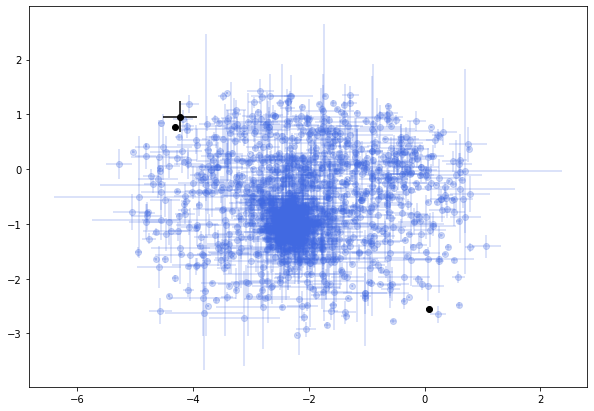

In [55]:
plt.figure(figsize=(10, 7))
plt.errorbar(clustered.pmra, clustered.pmdec,
             xerr=clustered.pmra_error, yerr=clustered.pmdec_error,
             color='royalblue', alpha=.25, fmt='o');
plt.errorbar(missing_dist.pmra, missing_dist.pmdec,
             xerr=missing_dist.pmra_error, yerr=missing_dist.pmdec_error,
             color='black', fmt='o');

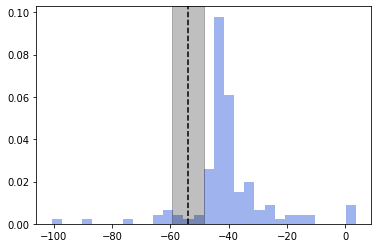

In [59]:
plt.hist(clustered.radial_velocity, bins=30, density=True, color='royalblue', alpha=.5);

for _, m in missing_dist.iterrows():
    plt.axvline(m.radial_velocity, ymin=0., ymax=1., linestyle='--', color='black');
    plt.axvspan(m.radial_velocity-m.radial_velocity_error,
                m.radial_velocity+m.radial_velocity_error, color='black', alpha=.25)